In [104]:
from imutils.object_detection import non_max_suppression
from google.colab.patches import cv2_imshow
import numpy as np
import argparse
import time
import cv2

In [105]:
img=cv2.imread("/content/drive/MyDrive/east_detection_test2.png")

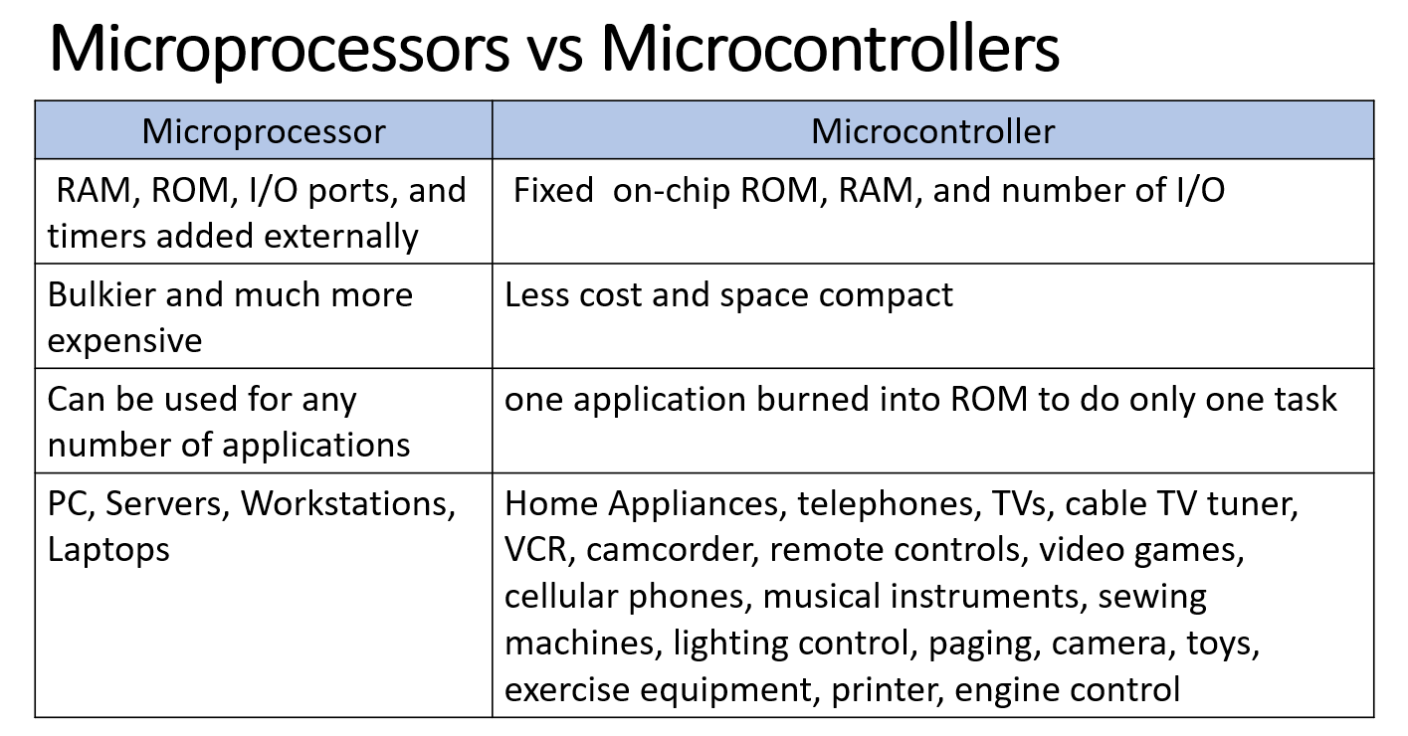

In [106]:
#Preprocessing


(oH,oW)=img.shape[:2]
reqht=oH-(oH %32)
reqwt=oW-(oW %32)


image = cv2.resize(img, (reqwt, reqht))

cv2_imshow(image)

In [107]:
#Loading network
eastnet=cv2.dnn.readNet("/content/drive/MyDrive/frozen_east_text_detection.pb")

In [108]:
outputLayers = []
outputLayers.append("feature_fusion/Conv_7/Sigmoid")
outputLayers.append("feature_fusion/concat_3")


In [109]:
#image to blob

blob = cv2.dnn.blobFromImage(image, 1.0, (reqwt, reqht),
                             (123.68, 116.78, 103.94), swapRB=True, crop=False)


In [110]:
#passing the blob
eastnet.setInput(blob)
output = eastnet.forward(outputLayers)
scores = output[0] #scores of each bbox
geometry = output[1] #coordinates of each bbox


In [111]:
print(scores.shape,geometry.shape, sep='\n')

(1, 1, 184, 352)
(1, 5, 184, 352)


In [112]:
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

for y in range(0, numRows):
    # extract the scores (probabilities), followed by the
    # geometrical data used to derive potential bounding box
    # coordinates that surround text
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]

    for x in range(0, numCols):
        # if our score does not have sufficient probability, ignore it
        if scoresData[x] < 0.5:
            continue

        # compute the offset factor as our resulting feature maps will
        # be 4x smaller than the input image
        (offsetX, offsetY) = (x * 4.0, y * 4.0)

        # extract the rotation angle for the prediction and then
        # compute the sin and cosine
        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)

        # use the geometry volume to derive the width and height of
        # the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]

        # compute both the starting and ending (x, y)-coordinates for
        # the text prediction bounding box
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)

        # add the bounding box coordinates and probability score to
        # our respective lists
        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])


In [113]:
print(len(rects),len(confidences), sep='\n')

6266
6266


In [114]:
#Apply Non Max Suppression to remove duplicate bboxes

boxes = non_max_suppression(np.array(rects), probs=confidences)

In [115]:
print(len(boxes))
print(boxes[0])

83
[1036  531 1123  562]


(740, 1415)


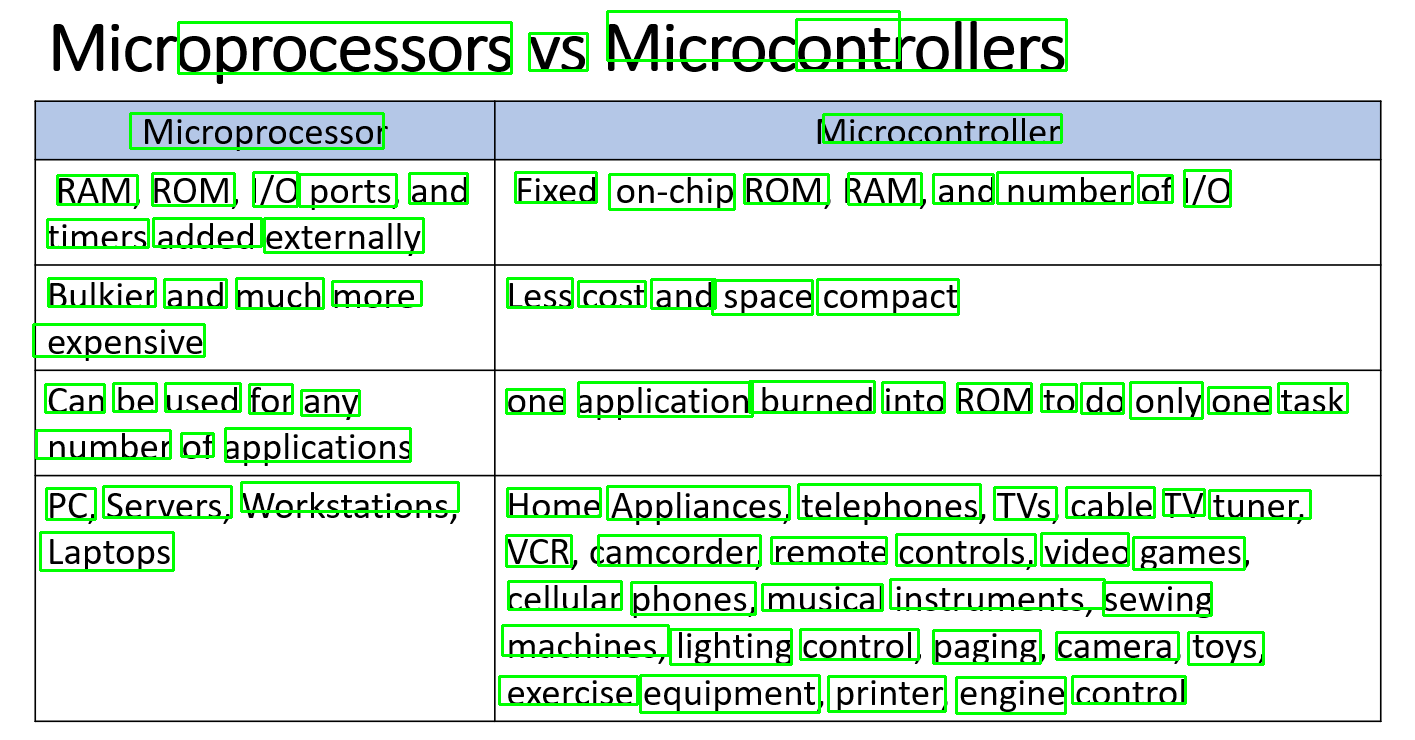

-1

In [116]:

print(img.shape[:2])
rW = oW / float(reqwt)
rH = oH / float(reqht)
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios

    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)

    # draw the bounding box on the image
    img=cv2.rectangle(img, (startX, startY), (endX, endY), (0, 255, 0), 2)

# show the output image
cv2_imshow(img)
cv2.waitKey(0)

In [117]:
cv2.imwrite("output.png",img)

True